# AgeGuesser

AgeGuesser is an end-to-end, deep-learning based, Age Estimation system. The proposed notebook contains all the required components to setup AgeGuesser and eventually, you can try it out using your own webcam!  

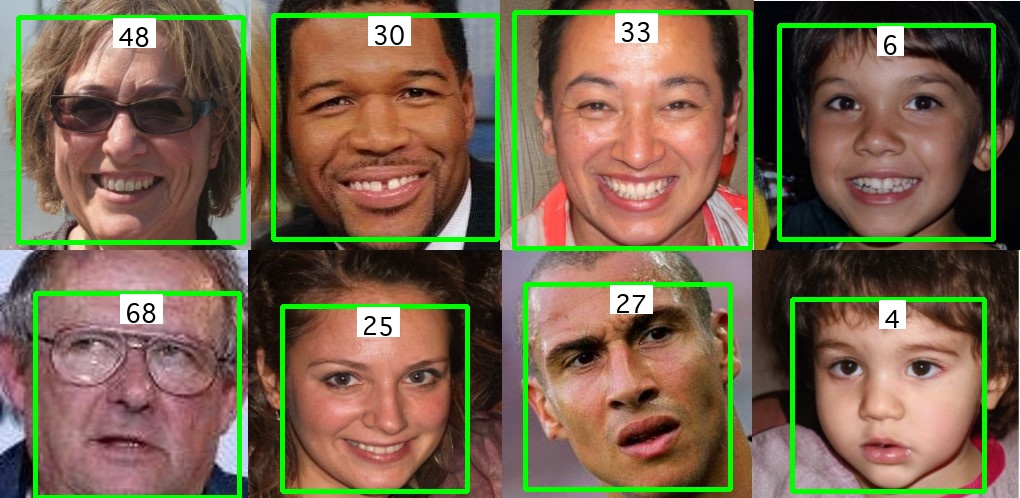

*Picture taken from [GTA2021 contest](http://gta2021.unisa.it/)*

## Object detection setup

Let's clone YoloV5 source code! The following blocks will download and setup all the requirements needed for our face detection component.

In [ ]:
!git clone https://github.com/ai-hazard/AgeGuesser.git

In [ ]:
%cd AgeGuesser

#Models

Put your models inside this directory and rename them:

1) age_2.h5 for age estimation

2) best_small.pt for face detection

In [ ]:
%cd yolov5

YoloV5 implementation is based on PyTorch. Generally Colab's Runtime already includes popular frameworks like Tensorflow and Torch, but let's be sure that all the requirements are actually satisfied.   

#Requirements installation

In [ ]:
!pip install -r requirements.txt

## Capture from webcam 

This code (a javascript-python bridge) allows to interface with your webcam and take pictures from it. This *hack* is needed to access external input devices on Google Colab, since you can't just use vanilla libraries as OpenCV to communicate with your webcam. 

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Age Estimation



The following block will load all the age estimation components and setup the environment.



1. Load the Age Estimation model
2. Setup YoloV5 environment
3. Load the Face Detection model
 



In [ ]:
import argparse
import time
from pathlib import Path
import os
import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, time_sync

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow

# Your Age Estimation model
def make_model0():
  pass
  

# Load Age Estimation model
weights_dir_custom = "../age_2.h5"
age_model = make_model0()
age_model.load_weights(weights_dir_custom)

# Face detection parameters
conf_thresh = 0.6
iou_thresh = 0.45
augment = None
project = "runs"
source = "photo.jpg"
nosave = False
save_conf = False
source, weights, view_img, save_txt, imgsz = "photo.jpg", "../best_small.pt", True, False, 320
save_img = True  # save inference images

webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
    ('rtsp://', 'rtmp://', 'http://', 'https://'))

# Directories
save_dir = "runs/detect/"

# Initialize
set_logging()
device = select_device('0')
half = device.type != 'cpu'  # half precision only supported on CUDA

# Load detection model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(imgsz, s=stride)  # check img_size
if half:
    model.half()  # to FP16

# Get names and colors
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once


vid_path, vid_writer = None, None

# Takes a cropped face and runs age prediction
def age_estimation(face):
 
    img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    imgg = img.reshape(1, 224, 224, 3)
    prediction = age_model.predict(imgg)[0][0]
    
    return prediction

# Load the input image, preprocess it and run the predictions 
def run_age_estimation(save_img=False, view_img=True):
    dataset = LoadImages(source, img_size=imgsz, stride=stride)
    t0 = time.time()
    for path, img, im0s, vid_cap,s in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_sync()
        pred = model(img, augment=augment)[0]

        # Apply NMS
        pred = non_max_suppression(pred, conf_thresh, iou_thresh, classes=None, agnostic=True)
        t2 = time_sync()

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = "runs" 
            txt_path = "" 
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    # crop im0 using xyxy
                    offset = 20
                    if int(xyxy[1]-offset) < 0 or int(xyxy[3]+offset) > im0.shape[1] or int(xyxy[0]-offset) < 0 or int(xyxy[2]+offset) > im0.shape[0]:
                    	offset = 0
                    	
                    face = im0[int(xyxy[1]-offset):int(xyxy[3]+offset),int(xyxy[0]-offset):int(xyxy[2]+offset)]

                    # run age classifier
                    age = int(age_estimation(face))
                    
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]}, age: {age}'
                        
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=2)
            print(f'{s}Done. ({t2 - t1:.3f}s)')
            # Show results
            cv2_imshow(im0)
            cv2.waitKey()


            
            # Save results (image with detections)
            if dataset.mode == 'image':
                cv2.imwrite(save_path + "/photo.jpg", im0)


def run_face_detection(save_img=False, view_img=True):
    dataset = LoadImages(source, img_size=imgsz, stride=stride)
    t0 = time.time()
    for path, img, im0s, vid_cap,s in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_sync()
        pred = model(img, augment=augment)[0]

        # Apply NMS
        pred = non_max_suppression(pred, conf_thresh, iou_thresh, classes=None, agnostic=True)
        t2 = time_sync()

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = "runs" 
            txt_path = "" 
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    # crop im0 using xyxy
                    offset = 20
                    if int(xyxy[1]-offset) < 0 or int(xyxy[3]+offset) > im0.shape[1] or int(xyxy[0]-offset) < 0 or int(xyxy[2]+offset) > im0.shape[0]:
                    	offset = 0
                    	
                    face = im0[int(xyxy[1]-offset):int(xyxy[3]+offset),int(xyxy[0]-offset):int(xyxy[2]+offset)]

                    
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]}'
                        
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=2)
            print(f'{s}Done. ({t2 - t1:.3f}s)')
            # Show results
            cv2_imshow(im0)
            cv2.waitKey()


            
            # Save results (image with detections)
            if dataset.mode == 'image':
                cv2.imwrite(save_path + "/photo.jpg", im0)

### Webcam test Age Estimation


This block initializes your webcam (allow permissions when requested), captures a frame and runs AgeGuesser to predict your age.

Unluckily there is no way to allow a realtime stream of frames from javascript to python, hence pictures must be taken one by one.

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print("Predicting... 🧙‍♂️")
  run_age_estimation()  
except Exception as err:
  pass

### Webcam test Face Detection


In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print("Predicting... 🧙‍♂️")
  run_face_detection()  
except Exception as err:
  pass